In [2]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from pathlib import Path
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sparse_dot_topn import awesome_cossim_topn
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import os
import lightgbm as lgb

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(0)
MAX_LEN = 64

In [4]:
data_dir = Path("data")
topics_df = pd.read_csv(data_dir / "topics.csv").set_index("id", drop=False)
content_df = pd.read_csv(data_dir / "content.csv")
correlations_df = pd.read_csv(data_dir / "correlations.csv")

# Helpers

In [5]:
def f2(recall, precision):
    return 5*precision*recall/(4*precision + recall)

def metric(pred_df):
    scores = np.zeros(pred_df.shape[0])

    for i, (gt, pred) in enumerate(zip(pred_df["content_ids"].values, pred_df["pred"].values)):
        hits = 0

        gt, pred = gt.split(), pred.split()

        for l in gt:
            if l in pred:
                hits += 1

        if hits > 0:           
            recall = hits / len(gt)
            precision = hits / len(pred)

            scores[i] = f2(recall, precision)

    return scores.mean()

In [6]:
# define some helper functions and classes to aid with data traversal
def print_markdown(md):
    display(Markdown(md))

class Topic:
    def __init__(self, topic_id):
        self.id = topic_id

    @property
    def parent(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return None
        else:
            return Topic(parent_id)

    @property
    def parent_title(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return ""
        else:
            return Topic(parent_id).title

    @property
    def parent_description(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return ""
        else:
            return Topic(parent_id).description

    @property
    def ancestors(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            parent = parent.parent
        return ancestors

    def ancestors_title(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            if parent.title != "":
                return parent.title
            parent = parent.parent

        return ""

    def ancestors_description(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            if parent.description != "":
                return parent.description
            parent = parent.parent

        return ""

    @property
    def siblings(self):
        if not self.parent:
            return []
        else:
            return [topic for topic in self.parent.children if topic != self]

    @property
    def content(self):
        if self.id in correlations_df.index:
            return [ContentItem(content_id) for content_id in correlations_df.loc[self.id].content_ids.split()]
        else:
            return tuple([]) if self.has_content else []

    def get_breadcrumbs_title(self, separator=" | ", include_self=True, include_root=True):
        ancestors = self.ancestors
        if include_self:
            ancestors = [self] + ancestors
        if not include_root:
            ancestors = ancestors[:-1]
        return separator.join([a.title for a in ancestors])

    def get_breadcrumbs_description(self, separator=" | ", include_self=True, include_root=True):
        ancestors = self.ancestors
        if include_self:
            ancestors = [self] + ancestors
        if not include_root:
            ancestors = ancestors[:-1]
        return separator.join([a.description for a in ancestors])

    @property
    def children(self):
        return [Topic(child_id) for child_id in topics_df[topics_df.parent == self.id].index]

    def subtree_markdown(self, depth=0):
        markdown = "  " * depth + "- " + self.title + "\n"
        for child in self.children:
            markdown += child.subtree_markdown(depth=depth + 1)
        for content in self.content:
            markdown += ("  " * (depth + 1) + "- " + "[" + content.kind.title() + "] " + content.title) + "\n"
        return markdown

    def __eq__(self, other):
        if not isinstance(other, Topic):
            return False
        return self.id == other.id

    def __getattr__(self, name):
        return topics_df.loc[self.id][name]

    def __str__(self):
        return self.title

    def __repr__(self):
        return f"<Topic(id={self.id}, title=\"{self.title}\")>"


class ContentItem:
    def __init__(self, content_id):
        self.id = content_id

    @property
    def topics_df(self):
        return [Topic(topic_id) for topic_id in topics_df.loc[correlations_df[correlations_df.content_ids.str.contains(self.id)].index].index]

    def __getattr__(self, name):
        return content_df.loc[self.id][name]

    def __str__(self):
        return self.title

    def __repr__(self):
        return f"<ContentItem(id={self.id}, title=\"{self.title}\")>"

    def __eq__(self, other):
        if not isinstance(other, ContentItem):
            return False
        return self.id == other.id

    def get_all_breadcrumbs(self, separator=" | ", include_root=True):
        breadcrumbs = []
        for topic in self.topics_df:
            new_breadcrumb = topic.get_breadcrumbs(separator=separator, include_root=include_root)
            if new_breadcrumb:
                new_breadcrumb = new_breadcrumb + separator + self.title
            else:
                new_breadcrumb = self.title
            breadcrumbs.append(new_breadcrumb)
        return breadcrumbs

# Preprocessing

In [7]:
topics_df = topics_df.fillna({"title": "", "description": ""})

topics_df.rename(columns={'id': "topics_id"})

topics_df["title"] = topics_df["id"].transform(lambda x: Topic(x).get_breadcrumbs_title())

topics_df["description"] = topics_df["id"].transform(lambda x: Topic(x).get_breadcrumbs_description())

topics_df["text"] = topics_df["title"] + " | " + topics_df["description"]

topics_df = topics_df[topics_df["has_content"]]

topics_df["label"] = LabelEncoder().fit_transform(topics_df["text"])

topics_df.reset_index(inplace=True, drop=True)

N_FOLDS = 3

kfolds = KFold(N_FOLDS, shuffle=True, random_state=0)

topics_df["fold"] = 0

for f, (train_ind, val_ind) in enumerate(kfolds.split(topics_df)):
    topics_df.loc[val_ind, "fold"] = f

topics_df.loc[(topics_df["category"] == "source") | (topics_df["fold"] > 0), "fold"] = 1



In [8]:
content_df = content_df.fillna({"title": "", "description": "", "text": ""})

content_df["text"] = content_df["title"] + " | " +\
                     content_df["description"].transform(lambda x: x[:526]) + " | " +\
                     content_df["text"].transform(lambda x: x[:526]) + " | " +\
                     content_df["language"]

In [9]:
correlations_df["content_ids"] = correlations_df["content_ids"].apply(lambda x: x.split())

correlations_df = correlations_df.explode('content_ids').reset_index(drop=True)

correlations_df['target'] = 1

In [10]:
topics_df.head()

,id,title,description,channel,category,level,language,parent,has_content,text,label,fold
0,t_00004da3a1b2,Откриването на резисторите | Открития и проект...,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True,Откриването на резисторите | Открития и проект...,51811,1
1,t_00068291e9a4,Entradas e saídas de uma função | Álgebra: fun...,Entenda um pouco mais sobre funções. | Nessa u...,8e286a,source,4,pt,t_d14b6c2a2b70,True,Entradas e saídas de uma função | Álgebra: fun...,16537,1
2,t_00069b63a70a,Transcripts | Flow Charts: Logical Thinking? |...,| This lesson is focused on flow charts. It s...,6e3ba4,source,3,en,t_4054df11a74e,True,Transcripts | Flow Charts: Logical Thinking? |...,46365,1
3,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True,Графики на експоненциални функции (Алгебра 2 н...,50903,1
4,t_0008768bdee6,100 સુધીનો સરવાળો | 100 સુધીના સરવાળા અને બાદબ...,37 અને 49 જેવી બે-અંકની સંખ્યાઓ ઉમેરતા શીખો. |...,5223e0,supplemental,4,gu,t_0da7a331d666,True,100 સુધીનો સરવાળો | 100 સુધીના સરવાળા અને બાદબ...,957,1


## Feature Engineering

In [11]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

def compute_embeddings_in_batches(df, model, batch_size=32):
    """
    Compute embeddings for a DataFrame in batches using a model.

    Args:
        df (pd.DataFrame): DataFrame containing text data.
        model: SentenceTransformer or similar model for encoding.
        batch_size (int): Number of samples per batch.

    Returns:
        list: List of computed embeddings.
    """
    embeddings = []
    for i in tqdm(range(0, len(df), batch_size), desc="Computing embeddings"):
        batch_texts = df['text'].iloc[i:i+batch_size].tolist()
        batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
        embeddings.extend(batch_embeddings)
    return embeddings

def compute_cosine_similarities(topic_df, content_df, top_n=20, min_score=0.01):
    """
    Compute matches between topics and content using NearestNeighbors with cosine similarity.

    Args:
        topic_df (pd.DataFrame): DataFrame containing topic embeddings.
        content_df (pd.DataFrame): DataFrame containing content embeddings.
        top_n (int): Number of top matches to return.
        min_score (float): Minimum similarity score threshold.

    Returns:
        pd.DataFrame: DataFrame containing topic-content matches and scores.
    """
    topic_embeddings = np.vstack(topic_df['embedding'].values)
    content_embeddings = np.vstack(content_df['embedding'].values)

    # Fit NearestNeighbors model
    nn_model = NearestNeighbors(n_neighbors=top_n, metric='cosine').fit(content_embeddings)
    distances, indices = nn_model.kneighbors(topic_embeddings)

    # Retrieve matches based on NearestNeighbors output
    matches = []
    for i, topic_id in enumerate(topic_df['id']):
        for j, dist in zip(indices[i], distances[i]):
            matches.append({
                'topic_id': topic_id,
                'content_id': content_df.iloc[j]['id'],
                'consine_dist': dist
            })

    return pd.DataFrame(matches)

def process_language_batches(topics_df, content_df, model, batch_size=32):
    """
    Process topic-content matches for each language batch.

    Args:
        topics_df (pd.DataFrame): DataFrame containing all topics.
        content_df (pd.DataFrame): DataFrame containing all content.
        model: SentenceTransformer or similar model for encoding.
        batch_size (int): Number of samples per batch.

    Returns:
        pd.DataFrame: Combined results of all language batches.
    """
    result_dfs = []
    languages = topics_df[topics_df["fold"] == 0]["language"].unique()[::-1]  # Reverse language order

    for lang in languages:
        print(f"Processing language: {lang}")
        topic_batch = topics_df[topics_df["language"] == lang].reset_index(drop=True)
        content_batch = content_df[content_df["language"] == lang].reset_index(drop=True)

        if content_batch.empty:
            print(f"No content found for language: {lang}")
            continue

        batch_results = compute_cosine_similarities(topic_batch, content_batch)
        result_dfs.append(batch_results)
        print("Completed processing.\n")

    combined_results = pd.concat(result_dfs, ignore_index=True) if result_dfs else pd.DataFrame()
    return combined_results

def process_batches(topics_df, content_df, model, batch_size=32):
    
    results = compute_cosine_similarities(topics_df, content_df)
    print("Completed processing.\n")

    return results

# Load model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device='cuda')


print("Computing topic embeddings...")
topics_df['embedding'] = compute_embeddings_in_batches(topics_df, model)

print("Computing content embeddings...")
content_df['embedding'] = compute_embeddings_in_batches(content_df, model)

# Process matches
#matches = process_language_batches(topics_df, content_df, model)
matches = process_batches(topics_df, content_df, model)

Computing topic embeddings...


Computing embeddings: 100%|██████████| 1923/1923 [02:45<00:00, 11.64it/s]


Computing content embeddings...


Computing embeddings: 100%|██████████| 4814/4814 [05:47<00:00, 13.87it/s]


Completed processing.



In [12]:
matches

,topic_id,content_id,consine_dist
0,t_00004da3a1b2,c_1cfd566d62dc,0.326107
1,t_00004da3a1b2,c_0d7bbffdb71f,0.335247
2,t_00004da3a1b2,c_265245f16ab1,0.352079
3,t_00004da3a1b2,c_797db4bb49dd,0.352266
4,t_00004da3a1b2,c_01e7287c59a8,0.363410
...,...,...,...
1230335,t_fffe811a6da9,c_c850dc7de9e3,0.288347
1230336,t_fffe811a6da9,c_609de91b7e53,0.290371
1230337,t_fffe811a6da9,c_781468b3485c,0.292342
1230338,t_fffe811a6da9,c_b3273878bea1,0.292550


In [13]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sparse_dot_topn import awesome_cossim_topn


def compute_matches(topic_df, content_df, top_n=20, min_score=0.01):
    """
    Compute matches between topics and content using TF-IDF similarity.
    
    Args:
        topic_df (pd.DataFrame): DataFrame containing topic data.
        content_df (pd.DataFrame): DataFrame containing content data.
        top_n (int): Maximum number of top matches to keep per topic.
        min_score (float): Minimum similarity score threshold.
    
    Returns:
        pd.DataFrame: DataFrame containing topic-content matches and scores.
    """

    tfidf = TfidfVectorizer(analyzer="char", ngram_range=(4, 4), min_df=2)
    text_data = pd.concat([content_df["text"], topic_df["text"]])
    
    tfidf.fit(text_data)

    print(f"Vocabulary size: {len(tfidf.vocabulary_)} | Topics: {topic_df.shape[0]} | Content: {content_df.shape[0]}")
    
    V_topic = tfidf.transform(topic_df["text"])
    V_content = tfidf.transform(content_df["text"])
    
    # Compute sparse cosine similarity matrix
    similarity_matrix = awesome_cossim_topn(V_topic, V_content.T, 20, 0.01, use_threads=True, n_jobs=4)
    
    topic_indices, content_indices = similarity_matrix.nonzero()
    match_scores = similarity_matrix.data

    match_df = pd.DataFrame({
        "topic_id": topic_df.iloc[topic_indices]["id"].values,
        "content_id": content_df.iloc[content_indices]["id"].values,
        "match_score": match_scores
    })
    
    return match_df


def process_language_batches(topics_df, content_df):
    """
    Process topic-content matches for each language batch.
    
    Args:
        topics_df (pd.DataFrame): DataFrame containing all topics.
        content_df (pd.DataFrame): DataFrame containing all content.
        use_title_only (bool): Whether to use only titles for matching.
    
    Returns:
        pd.DataFrame: Combined results of all language batches.
    """
    result_dfs = []
    languages = topics_df[topics_df["fold"] == 0]["language"].unique()[::-1]
    
    for lang in languages:
        print(f"Processing language: {lang}")
        topic_batch = topics_df[topics_df["language"] == lang].reset_index(drop=True)
        content_batch = content_df[content_df["language"] == lang].reset_index(drop=True)

        if content_batch.empty:
            print(f"No content found for language: {lang}")
            continue

        batch_results = compute_matches(topic_batch, content_batch)
        result_dfs.append(batch_results)
        print("Completed processing.\n")
    
    combined_results = pd.concat(result_dfs, ignore_index=True) if result_dfs else pd.DataFrame()
    return combined_results


matches_tfidf = process_language_batches(topics_df, content_df)


Processing language: sw
Vocabulary size: 28530 | Topics: 2082 | Content: 1447
Completed processing.

Processing language: as
Vocabulary size: 16303 | Topics: 126 | Content: 641
Completed processing.

Processing language: fil
Vocabulary size: 4327 | Topics: 224 | Content: 516
Completed processing.

Processing language: pt
Vocabulary size: 52219 | Topics: 3425 | Content: 10435
Completed processing.

Processing language: fr
Vocabulary size: 44442 | Topics: 3034 | Content: 10682
Completed processing.

Processing language: bn


Vocabulary size: 30076 | Topics: 1731 | Content: 2513
Completed processing.

Processing language: hi
Vocabulary size: 48502 | Topics: 1373 | Content: 4042
Completed processing.

Processing language: gu
Vocabulary size: 50521 | Topics: 1809 | Content: 3677
Completed processing.

Processing language: es
Vocabulary size: 128475 | Topics: 11769 | Content: 30844
Completed processing.

Processing language: en
Vocabulary size: 223190 | Topics: 28053 | Content: 65939
Completed processing.



In [14]:
pred_df = matches.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})
pred_df = pred_df.merge(pd.read_csv(data_dir / "correlations.csv"), on="topic_id")

metric(pred_df)

0.1141402511469085

In [15]:
matches.shape, matches_tfidf.shape

((1230340, 3), (1072520, 3))

In [16]:
topics_df.columns = [f"topic_{col}" for col in topics_df.columns]
content_df.columns = [f"content_{col}" for col in content_df.columns]

In [17]:
matches = matches.merge(topics_df, on="topic_id", how="left")
matches = matches.merge(content_df, on="content_id", how="left")

In [18]:
matches["topic_language"] = matches["topic_language"].astype("category")
matches["topic_category"] = matches["topic_category"].astype("category")
matches['content_language'] = matches['content_language'].astype("category")
matches["content_kind"] = matches["content_kind"].astype("category")
matches["topic_channel"] = matches["topic_channel"].astype("category")

In [ ]:
# Aggregate match scores
topic_features = matches.groupby("topic_id").agg(
    score_max=("match_score", "max"),
    score_min=("match_score", "min"),
    score_mean=("match_score", "mean"),
)

# Merge back to topics DataFrame
matches = matches.merge(topic_features, left_on="topic_id", right_on="topic_id", how="left")

KeyError: "Column 'cosine_similarity' does not exist!"

In [79]:
correlations_df['content_id'] = correlations_df['content_ids']
matches = matches.merge(correlations_df[["topic_id", "content_id", "target"]], on=["topic_id", "content_id"], how="left")
matches["target"].fillna(0, inplace=True)

In [80]:
matches

,topic_id,content_id,cosine_similarity,topic_title,topic_description,topic_channel,topic_category,topic_level,topic_language,topic_parent,...,content_description,content_kind,content_text,content_language,content_copyright_holder,content_license,score_max,score_min,score_mean,target
0,t_00269d6e7e45,c_711c3765a146,0.858340,"Kuzidisha kwa makumi, mamia, na maelfu | Kuzid...",Jifunze kuzidisha namba nzima kwa vigawe vya k...,0c929f,source,4,sw,t_1c0c5d025888,...,Sal anakokotoa mafumbo kwa kuzidisha sehemu kw...,video,Kuzidisha sehemu fumbo: baiskeli | Sal anakoko...,sw,Khan Academy,CC BY-NC-SA,0.858340,0.806994,0.822996,0.0
1,t_00269d6e7e45,c_f53e6e4e2a59,0.855023,"Kuzidisha kwa makumi, mamia, na maelfu | Kuzid...",Jifunze kuzidisha namba nzima kwa vigawe vya k...,0c929f,source,4,sw,t_1c0c5d025888,...,## Namna ya kuzidisha sehemu\n\nHatua ya kwanz...,video,Kuzidisha sehemu 2: 5/6 x 2/3 | ## Namna ya ku...,sw,Khan Academy,CC BY-NC-SA,0.858340,0.806994,0.822996,0.0
2,t_00269d6e7e45,c_37a651e34511,0.854024,"Kuzidisha kwa makumi, mamia, na maelfu | Kuzid...",Jifunze kuzidisha namba nzima kwa vigawe vya k...,0c929f,source,4,sw,t_1c0c5d025888,...,Loh! Mtu mmoja anajaribu kukokotoa hili swali ...,video,Kuzidisha sehemu mafumbo: boga | Loh! Mtu mmoj...,sw,Khan Academy,CC BY-NC-SA,0.858340,0.806994,0.822996,0.0
3,t_00269d6e7e45,c_ef4b3f95f819,0.836841,"Kuzidisha kwa makumi, mamia, na maelfu | Kuzid...",Jifunze kuzidisha namba nzima kwa vigawe vya k...,0c929f,source,4,sw,t_1c0c5d025888,...,"Sal anaonesha mbinu za kujumlisha kwa kichwa, ...",video,Kukokotoa namba za tarakimu tatu kwa kichwa | ...,sw,Khan Academy,CC BY-NC-SA,0.858340,0.806994,0.822996,0.0
4,t_00269d6e7e45,c_9752b6200dbb,0.832388,"Kuzidisha kwa makumi, mamia, na maelfu | Kuzid...",Jifunze kuzidisha namba nzima kwa vigawe vya k...,0c929f,source,4,sw,t_1c0c5d025888,...,Sal anakokotoa mafumbo kwa kuzidisha sehemu 2\n\n,video,Kuzidisha sehemu fumbo: udobi | Sal anakokotoa...,sw,Khan Academy,CC BY-NC-SA,0.858340,0.806994,0.822996,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072515,t_fff830472691,c_ea457dd5dd3b,0.649105,Scalar Projections | Vector Analysis | Analysi...,| | | |,fef095,source,4,en,t_c75d6acecf78,...,,video,Representation of a Vector | | | en,en,NaN,NaN,0.801951,0.640350,0.691993,0.0
1072516,t_fff830472691,c_b1c13f00e579,0.646520,Scalar Projections | Vector Analysis | Analysi...,| | | |,fef095,source,4,en,t_c75d6acecf78,...,,document,2.2 Resolution of vectors | | | en,en,NaN,NaN,0.801951,0.640350,0.691993,0.0
1072517,t_fff830472691,c_d97b02153f11,0.646116,Scalar Projections | Vector Analysis | Analysi...,| | | |,fef095,source,4,en,t_c75d6acecf78,...,,html5,Vector Direction | | | en,en,NaN,NaN,0.801951,0.640350,0.691993,0.0
1072518,t_fff830472691,c_75d4e9bf221d,0.641599,Scalar Projections | Vector Analysis | Analysi...,| | | |,fef095,source,4,en,t_c75d6acecf78,...,,html5,16.E: Vector Calculus (Exercises) | | 16.1: V...,en,CSU and Merlot,CC BY-NC-SA,0.801951,0.640350,0.691993,0.0


In [81]:
matches['topic_fold'].value_counts()

1    907560
0    164960
Name: topic_fold, dtype: int64

# Training model

In [ ]:
# Feature columns for LightGBM
feature_columns = [
    "cosine_similarity",
    "score_max", 
    "score_min", 
    "score_mean",
    "topic_language", "content_language",
    "topic_category",
    "topic_channel",
    "topic_level",
    "content_kind"]

train_df, val_df = matches[matches['topic_fold'] == 1], matches[matches['topic_fold'] == 0]

# Create LightGBM datasets
train_data = lgb.Dataset(train_df[feature_columns], label=train_df['target'])
val_data = lgb.Dataset(val_df[feature_columns], label=val_df['target'])

# Define LightGBM parameters
lgb_param = {"objective": "binary",
             "metric": 'auc',
             "boosting": "gbdt",
             "learning_rate": 0.05,
             "is_unbalance": True,
}

evals_result = {}

# Train the LightGBM model
model = lgb.train(
    lgb_param,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=800,
    callbacks=[lgb.record_evaluation(evals_result)]
)

model.save_model("lgbm_model.txt")

[LightGBM] [Info] Number of positive: 57126, number of negative: 850434
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 907560, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062945 -> initscore=-2.700487
[LightGBM] [Info] Start training from score -2.700487


In [83]:
y_pred = model.predict(val_df[feature_columns])
roc_auc_score(val_df['target'], y_pred )

0.8841627985304892

In [84]:
predicted_matches = val_df
predicted_matches['pred'] = y_pred

/home/cesar.carneiro/learning-equality-curriculum-recommendations/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
predicted_matches["rank"] = predicted_matches.groupby("topic_id")["pred"].rank(method="first", ascending=False)

predicted_matches["gap"] = predicted_matches.groupby("topic_id")["pred"].transform("max") - predicted_matches["pred"]

predicted_matches["content_dist"] = predicted_matches["gap"] + predicted_matches.groupby("content_id")["pred"].transform("max") - predicted_matches["pred"]

predicted_matches["content_rank"] = predicted_matches.groupby("content_id")["content_dist"].rank(method="first")

pred_df = predicted_matches[(predicted_matches["rank"] == 1) | ((predicted_matches["gap"] < 0.50))]
 

pred_df = pred_df.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})

pred_df

/home/cesar.carneiro/learning-equality-curriculum-recommendations/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/cesar.carneiro/learning-equality-curriculum-recommendations/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cesar.carneiro/learning-equality

,topic_id,pred
0,t_000d1fb3f2f5,c_ad2e31077935 c_55e7244b3fea c_efd54df3ac98 c...
1,t_0016d30772f3,c_d59e0f06425a c_a66b3efb4d2f c_242ddc729eec c...
2,t_001bcbb22694,c_ca5674a9f041 c_c6ddf506dd18 c_f6ba87c9334d c...
3,t_0020bde404c1,c_b16fba21a861 c_bedd1f7ea858 c_9a8f57b2d0dd c...
4,t_00260f878951,c_382eccd9d1dc c_05e1e5d5ef0c c_784eccf02477 c...
...,...,...
8243,t_ffb0a70e5e48,c_f3b75faf5480 c_490b28ffb87f c_f7c218334f49 c...
8244,t_ffb1d959761e,c_d83b35946e90 c_530bc4d72787 c_7efe3ab8c8da c...
8245,t_ffba5459a977,c_9c264389bf59 c_d88cc872e0b7 c_7a564b645f4c c...
8246,t_ffdc013937fc,c_102505e19a81 c_bc6e16226275 c_9918248dbf7a c...


# Evaluete

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

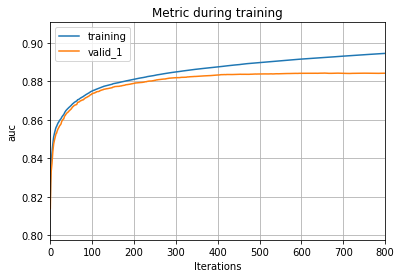

In [ ]:
lgb.plot_metric(evals_result, metric='auc')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

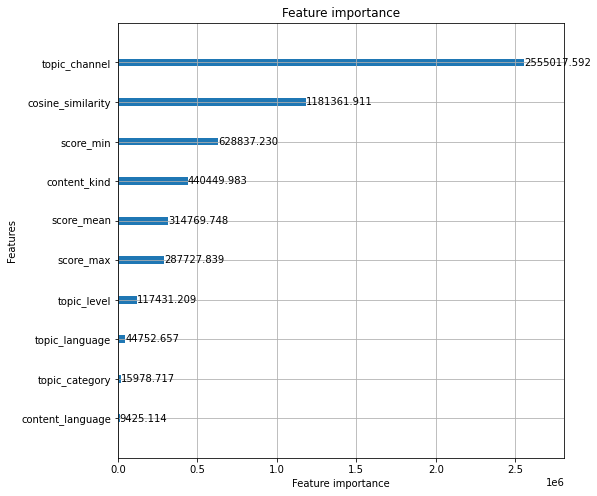

In [88]:
lgb.plot_importance(importance_type="gain", booster=model, figsize=(8, 8))

In [14]:
metric(pred_df.merge(pd.read_csv(data_dir / "correlations.csv"), on="topic_id"))

NameError: name 'pred_df' is not defined